In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
beta = 100.
t = 1.

In [35]:
#definition of FourierTransforms
def matsubara_fft(G_tau):
    N = G_tau.shape[0]
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft(G_tau*np.exp(1j*np.pi*k/N))
def matsubara_fft_trick(G_tau):
    N = G_tau.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft( (G_tau+0.5) *np.exp(1j*np.pi*k/N)) + 1./(1j*freq)
#numpy orders frequencies differently so one has to convert frequencies
def matsubara_freq(N):
    return np.pi/beta *(-2*(np.fft.fftfreq(N))*N+1)
def matsubara_ifft(G_omega):
    N = G_omega.shape[0]
    k = np.arange(N,dtype='float')
    return N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega)
#following has to be improved:
def matsubara_ifft_trick(G_omega):
    N = G_omega.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N,dtype='float')
    return -1/2+N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega-1./(1j*freq) )

In [36]:
N=501
tau = linspace(0,beta*(1.-1./N),N)
dtau = beta/N
freq = matsubara_freq(N)

In [54]:
def self_energy(G0_omega,U):
    G0_tau = matsubara_ifft_trick(G0_omega)
    #G0_product_tau = -U**2*G0_tau**3
    G0_minus_tau = -np.roll(G0_tau[::-1],1)
    G0_minus_tau[0] = -G0_minus_tau[0]
    G0_product_tau = -U**2 * G0_tau**2 * G0_minus_tau
    #G0_product_tau = -U**2 * G0_tau**3
    return matsubara_fft_trick(G0_product_tau)

In [55]:
from scipy.integrate import simps
Ne = N
Nk = N
k = linspace(-np.pi,np.pi, Nk)
epsilon_k = -2.*t*np.cos(k)
#D = 2.*t
D = 1.
def dos_bethe(e):
    return 2./(np.pi*D)*np.sqrt(1.-(e/D)**2)
def dos_cubic(e):
    return 1./(t*np.sqrt(2.*np.pi))*np.exp(-e**2/(2.*t))
def Gloc_omega(self_energy_omega):
    #return 1./Nk*np.sum(1./(1j*freq-epsilon_k[:, np.newaxis]-self_energy_omega),axis=0)
    ##
    energies_bethe = np.linspace(-D,D,Ne)
    denergies_bethe = energies_bethe[2] - energies_bethe[1]
    return simps( dos_bethe(energies_bethe)/(1j*freq[:,np.newaxis]-energies_bethe-self_energy_omega[:,np.newaxis]) ,dx=denergies_bethe)
    ##
    #energies_cubic = np.linspace(-10.*t,10*t,Ne)
    #denergies_cubic = energies_cubic[2] - energies_cubic[1]
    #return simps( dos_cubic(energies_cubic)/(1j*freq[:,np.newaxis]-energies_cubic-self_energy_omega[:,np.newaxis]) ,dx=denergies_cubic)

In [73]:
def DMFT_loop(G0_initial_omega,U,frac_new):
    G0_omega= G0_initial_omega
    #print "1/G0_initial = ", np.round(abs(1./G0_omega[::N/10]),2)
    self_e = self_energy(G0_omega,U)
    Gloc = Gloc_omega(self_e)
    G0_omega = frac_new * 1./(1./Gloc+self_e+U/2.) + (1.-frac_new) * G0_omega
    #print "1/Gloc = ", np.round(abs(1./Gloc[::N/10]),2)
    #print "Sigma = ", np.round(abs(self_e[::N/10]),2)
    #print "1/G0_new = ", np.round(abs(1./G0_omega[::N/10]),2)
    #print "-----------------------------------------------------------------------------------"
    return G0_omega, Gloc

In [74]:
def doit(a,U,I,J,frac_new):
    G0 = 1. / ( 1j*freq + a )
    #G0 = np.random.rand(freq.shape[0]) + 1j* np.random.rand(freq.shape[0])
    #meanfreq = 10.
    #std = 0.5
    #G0 = 1./(np.sqrt(np.pi*2.)*std) * np.exp(-1./2*((freq-meanfreq)/(std))**2)
    G=[G0]
    g_0 = G0
    for i in range(I*J):
        g_0, g_loc = DMFT_loop(g_0,U,frac_new)
        G.append(g_loc)
    fig, ax = plt.subplots(nrows=I,ncols=J,figsize=(12,15))
    fig.tight_layout()
    for i in range(I):
        for j in range(J):
            ax[i,j].set_title("a="+str(a)+" U="+str(U)+" iteration "+str(J*i+j))
            ax[i,j].plot(freq, G[J*i+j].real,"b+",label="real")
            ax[i,j].plot(freq, G[J*i+j].imag,"g+",label="imag")
            ax[i,j].set_ylim(-2.,2.)
            ax[i,j].grid()
            #ax[i,j].set_xlabel("$\omega$")
            #ax[i,j].legend()  

-----------------------------------------------------------------------------------
a =  2.0 U =  0.0
-----------------------------------------------------------------------------------
a =  2.0 U =  0.571428571429
-----------------------------------------------------------------------------------
a =  2.0 U =  1.14285714286
-----------------------------------------------------------------------------------
a =  2.0 U =  1.71428571429
-----------------------------------------------------------------------------------
a =  2.0 U =  2.28571428571
-----------------------------------------------------------------------------------
a =  2.0 U =  2.85714285714
-----------------------------------------------------------------------------------
a =  2.0 U =  3.42857142857
-----------------------------------------------------------------------------------
a =  2.0 U =  4.0


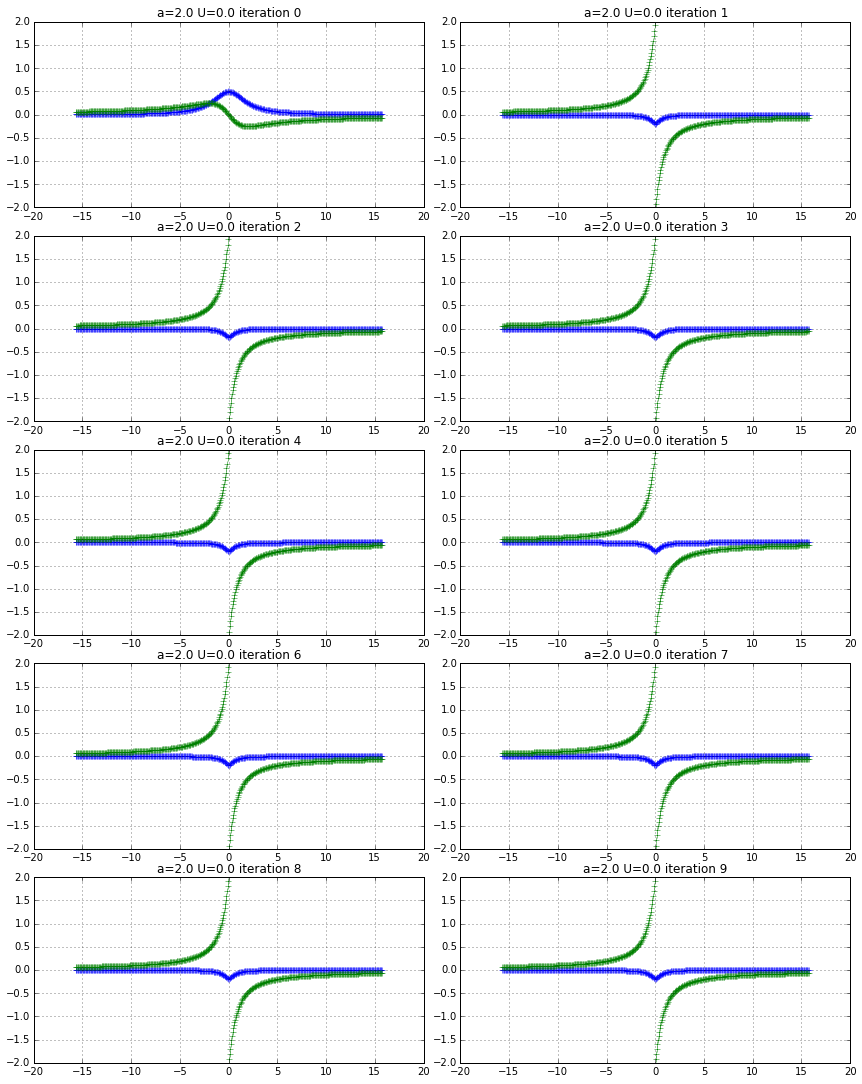

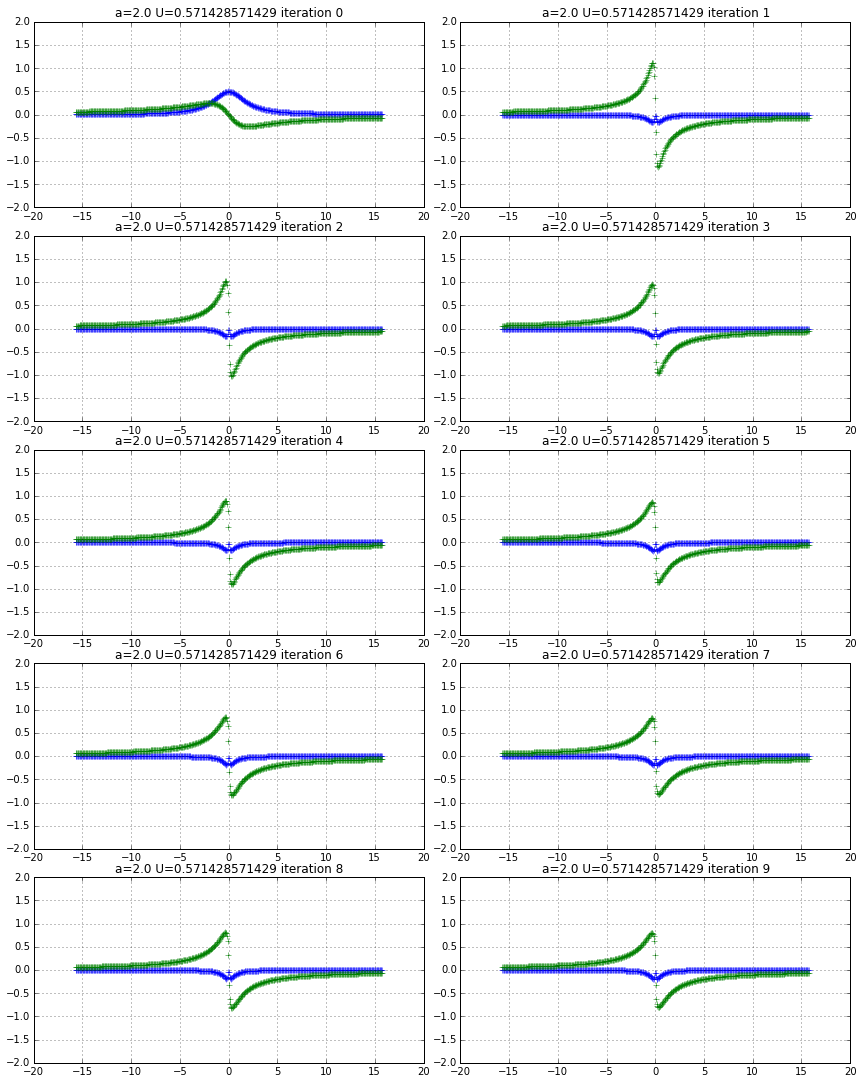

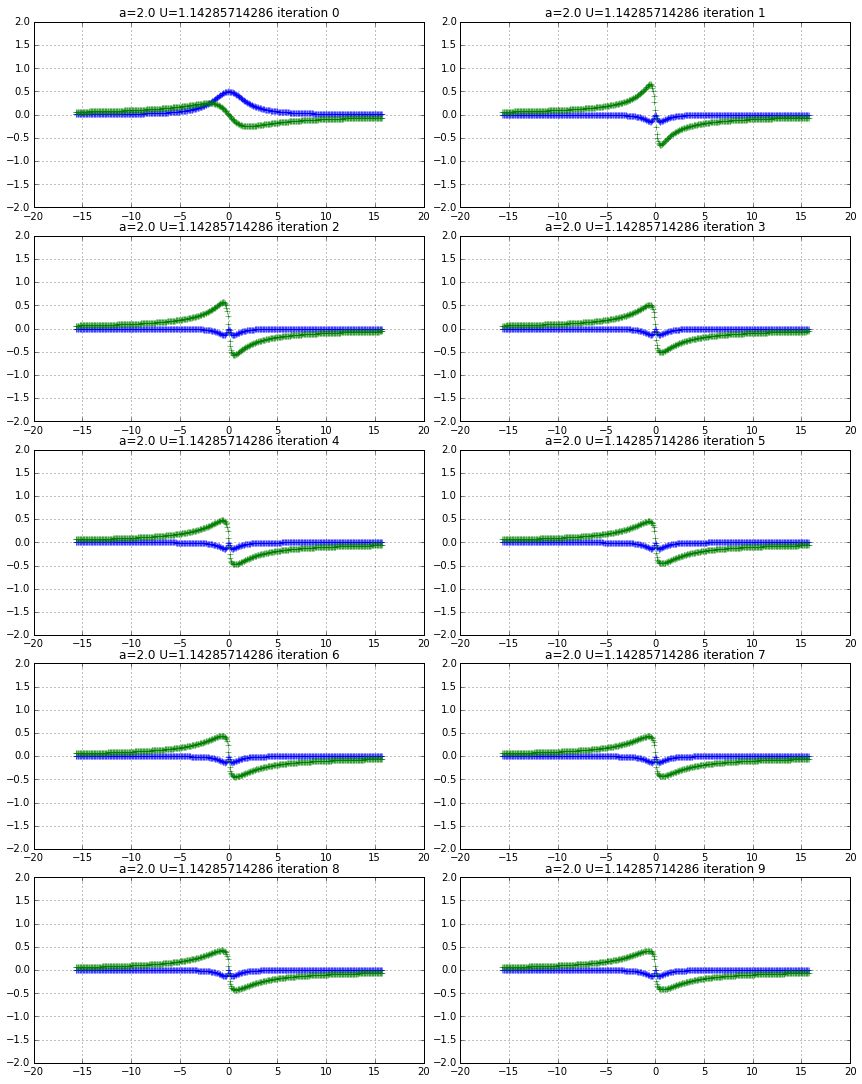

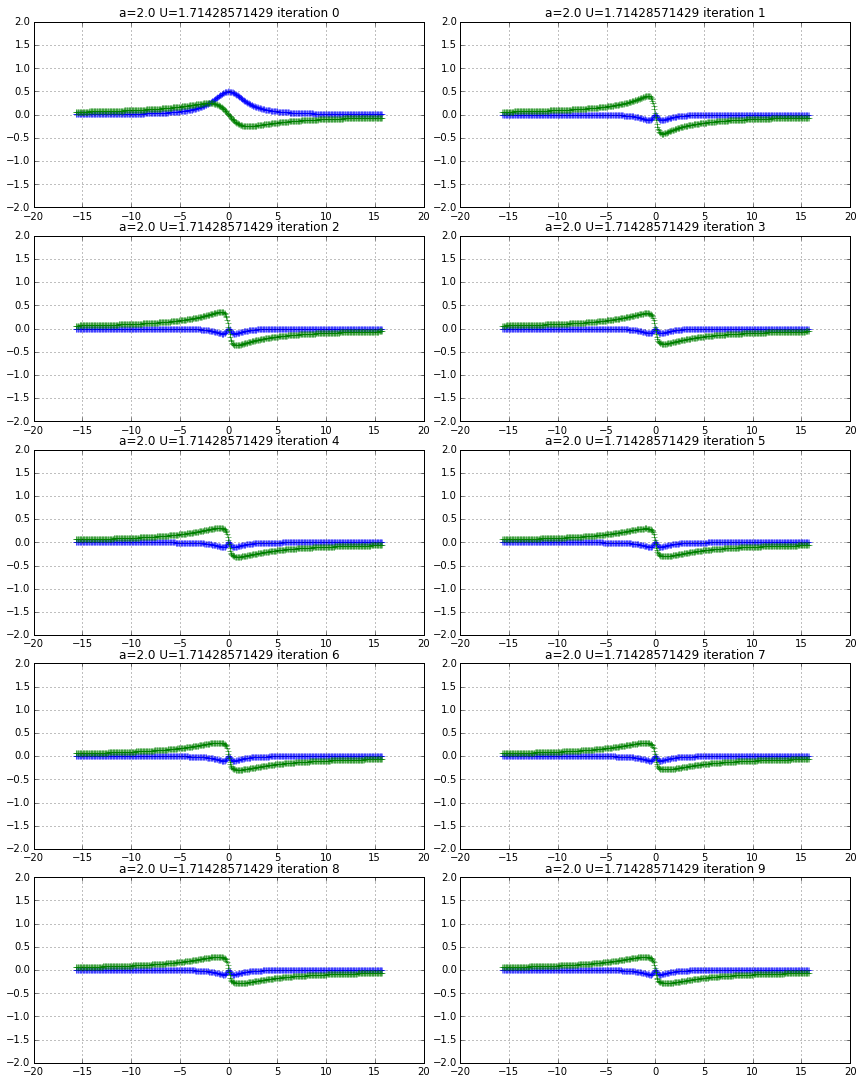

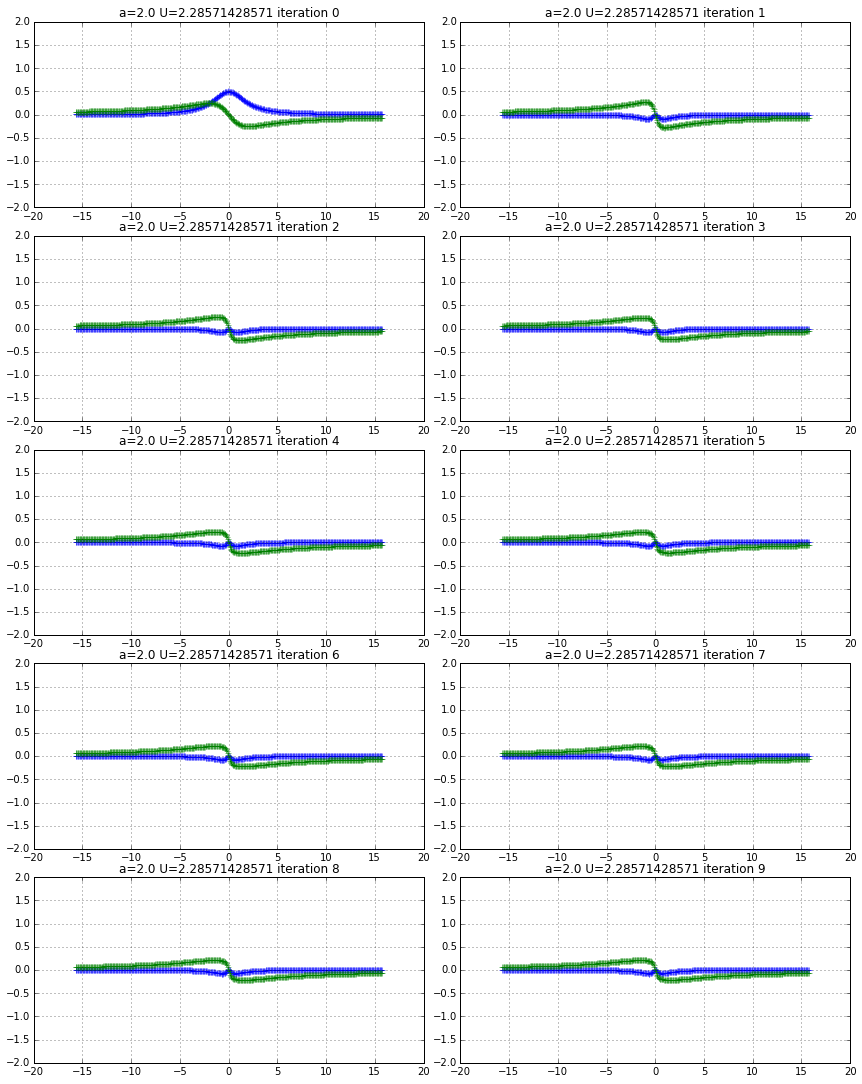

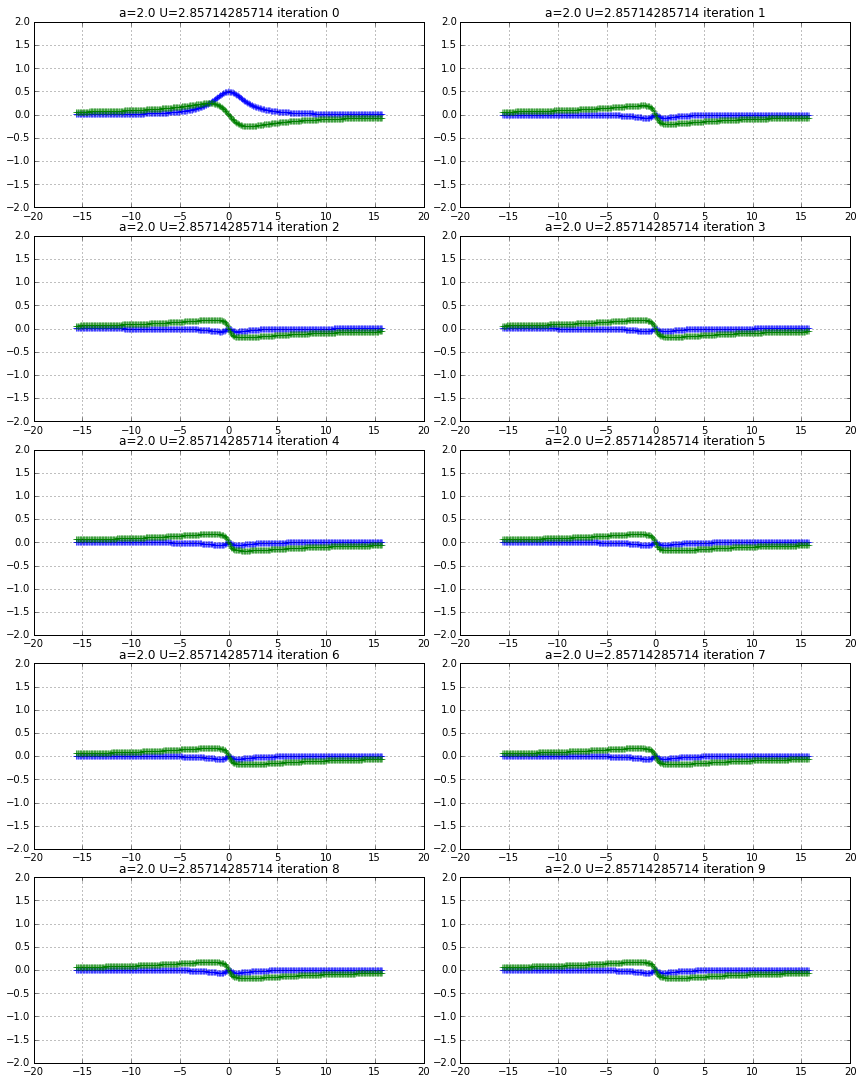

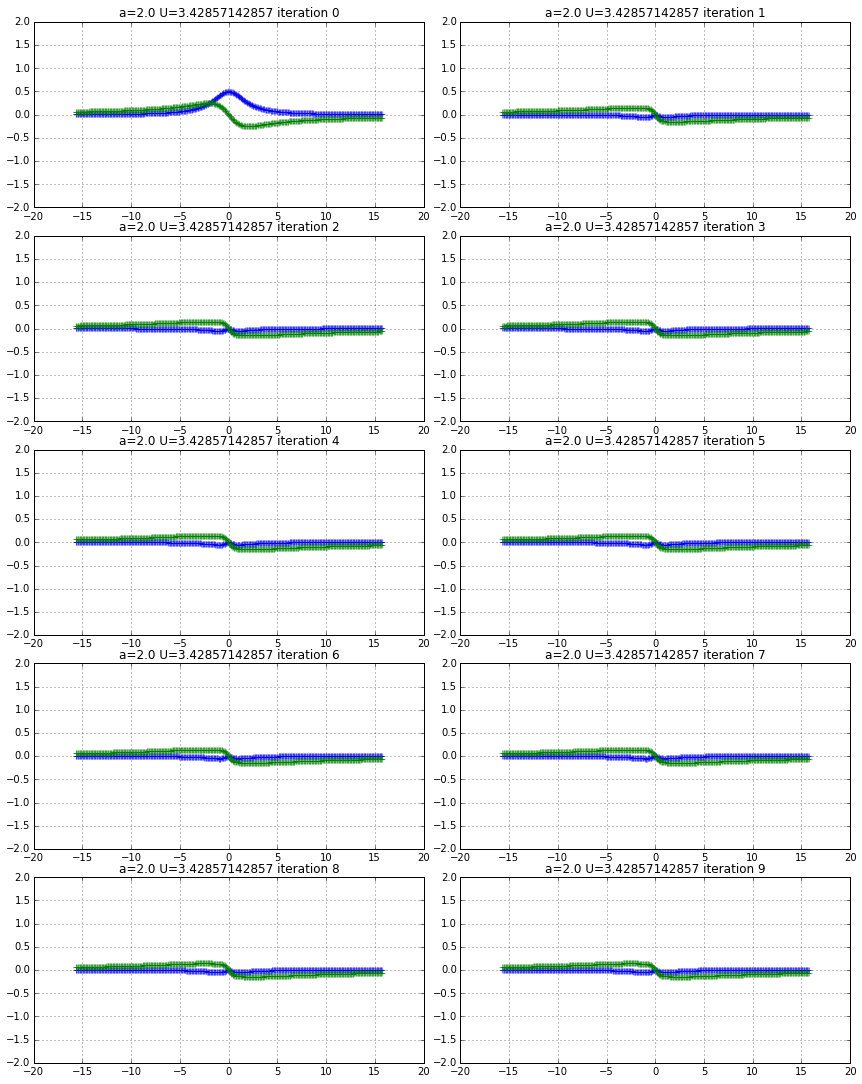

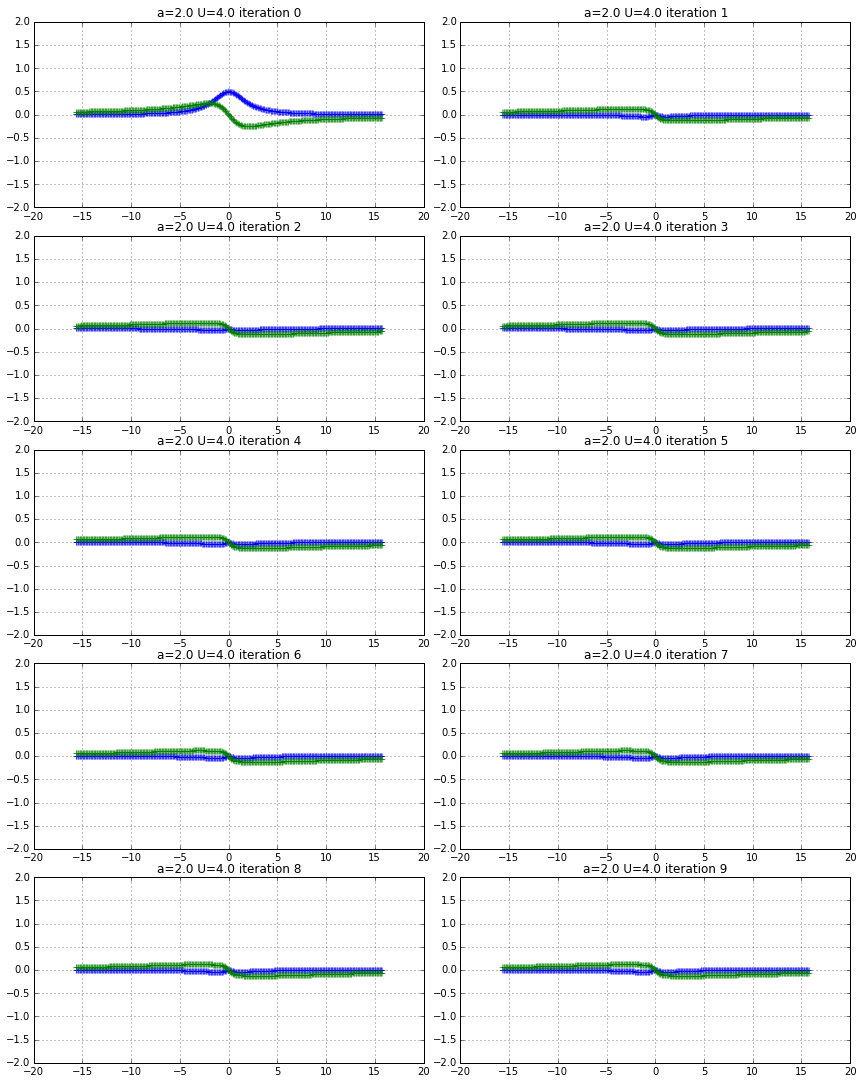

In [76]:
#for a in np.arange(1.,5.,2.): 
for u in np.linspace(0.,4.,8):
        a=2.
        print "-----------------------------------------------------------------------------------"
        print "a = ", a, "U = ", u
        "-----------------------------------------------------------------------------------"
        doit(a,u,5,2,0.3)